In [2]:
! hostname
! whoami
! pwd
# ! nvidia-smi

Akarshs-MacBook-Pro.local
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization/atari


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%run imports.py

In [5]:
[k for k in gym.registry.keys() if 'montezuma' in k.lower()]

['MontezumaRevenge-v0',
 'MontezumaRevengeDeterministic-v0',
 'MontezumaRevengeNoFrameskip-v0',
 'MontezumaRevenge-v4',
 'MontezumaRevengeDeterministic-v4',
 'MontezumaRevengeNoFrameskip-v4',
 'MontezumaRevenge-ram-v0',
 'MontezumaRevenge-ramDeterministic-v0',
 'MontezumaRevenge-ramNoFrameskip-v0',
 'MontezumaRevenge-ram-v4',
 'MontezumaRevenge-ramDeterministic-v4',
 'MontezumaRevenge-ramNoFrameskip-v4',
 'ALE/MontezumaRevenge-v5',
 'ALE/MontezumaRevenge-ram-v5']

In [148]:
env.envs[0].env.env.env.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [4]:
env = make_env('BreakoutNoFrameskip-v4', n_envs=8, device='mps')

NameNotFound: Environment `BreakoutNoFrameskip-v4` doesn't exist in namespace ALE. Did you mean: `Breakout-ram`?

In [325]:
env.single_action_space, env.action_space, env.single_observation_space, env.observation_space

(Discrete(18),
 MultiDiscrete([18 18 18 18 18 18 18 18]),
 Box(0, 255, (4, 84, 84), uint8),
 Box(0, 255, (8, 4, 84, 84), uint8))

In [326]:

obs, info = env.reset()
for _ in tqdm(range(2048)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
    # if rew.max()>0:
    #     print(rew.max())

  0%|          | 0/2048 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [252]:
ret_ext = torch.cat(env.key2past_rets['ret_ext']).tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0]

In [277]:
10000000//(128*8)

9765

In [288]:
9765//100

97

In [289]:
97*10

970

In [290]:
970/97

10.0

In [ ]:
torch.from_numpy(rew)

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [298]:
x = info['obs']
x.shape, x.dtype, x.device

(torch.Size([8, 84, 84]), torch.uint8, device(type='mps', index=0))

In [245]:
import random

In [246]:
random.seed(0)
np.random.seed(0)
env = make_env('Breakout', n_envs=8, device='mps', seed=0)
obs, info = env.reset()
for _ in tqdm(range(256)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
info['obs'].sum().item()

  0%|          | 0/256 [00:00<?, ?it/s]

9444516

In [78]:
random.seed(0)
np.random.seed(0)
env = make_env('Breakout', n_envs=8, device='mps', seed=0)
obs, info = env.reset()
for _ in tqdm(range(256)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
info['obs'].sum().item()

  0%|          | 0/256 [00:00<?, ?it/s]

9444516

In [115]:
from agent_atari import *
import torchinfo

In [116]:
# torchinfo.summary()

In [117]:
agent = Agent(env)
torchinfo.summary(agent, input_size=(args.batch_size,) + env.single_observation_space.shape)

NameError: name 'args' is not defined

In [118]:
(args.batch_size,) + env.single_observation_space.shape

NameError: name 'args' is not defined

In [119]:
vid = np.stack(env.past_obs).copy()
vid[:, :, -1, :] = 0
vid[:, :, :, -1] = 0
print(vid.shape)
vid = rearrange(vid, 't (H W) h w -> t (H h) (W w)', H=2, W=4)
print(vid.shape)

(257, 8, 84, 84)
(257, 168, 336)


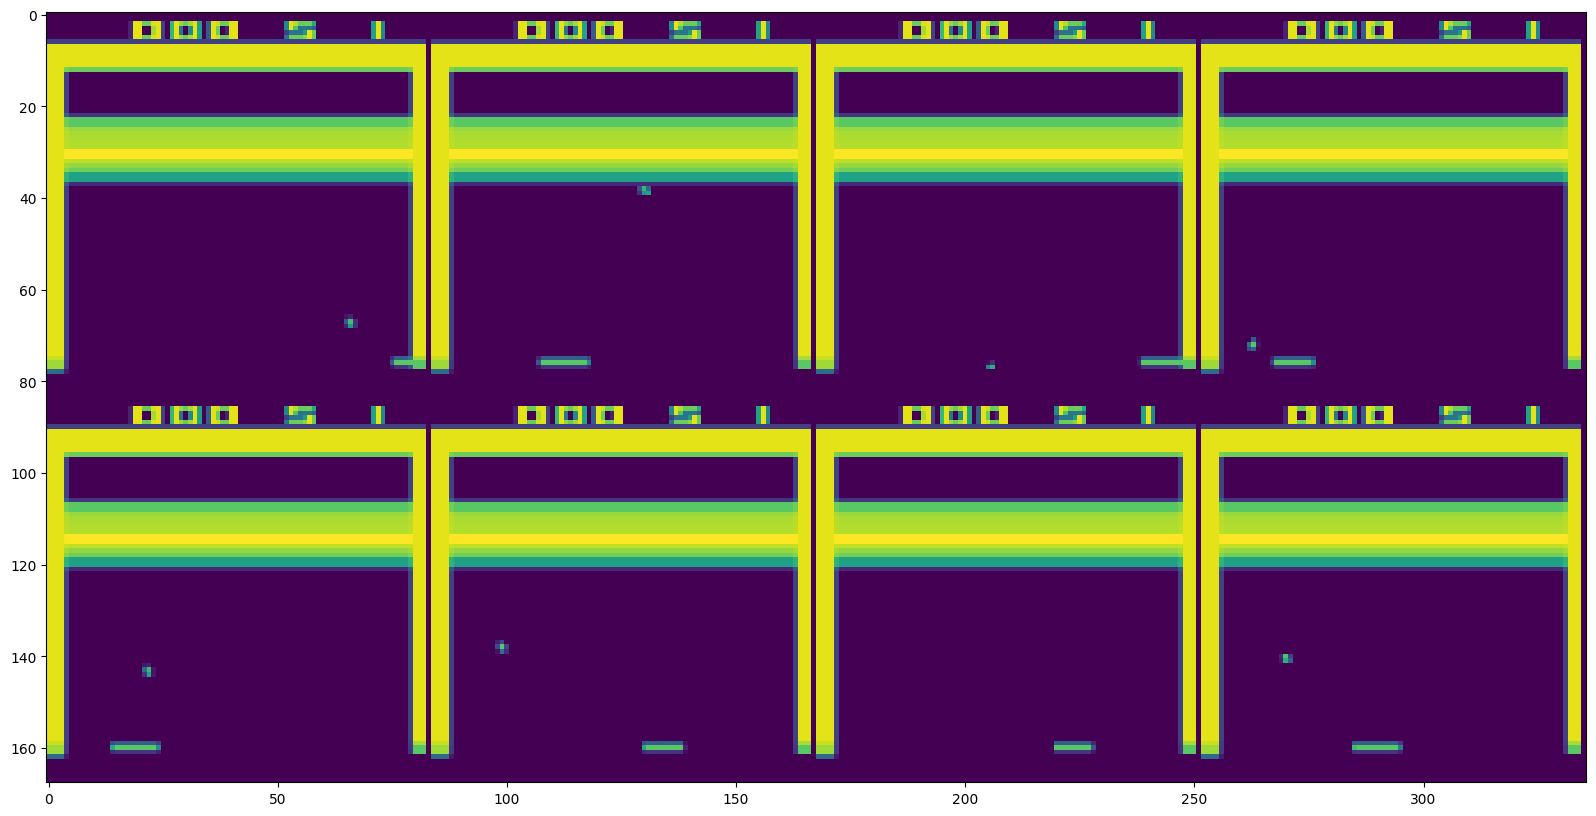

In [127]:
plt.figure(figsize=(20, 10))
plt.imshow(vid[-1])
plt.show()

In [86]:
np.random.randint(0, 2, size=6)

array([1, 1, 1, 1, 1, 0])

In [131]:
import wandb
wandb.init(project='test')

wandb: Currently logged in as: akarshkumar0101. Use `wandb login --relogin` to force relogin


In [141]:
wandb.log(dict(vid=wandb.Video(vid[:, None, :, :], fps=15)))

In [146]:
agent = Agent(env.single_observation_space.shape, env.single_action_space.n)

In [295]:
obs = torch.randn(128, 8, 4, 84, 84)
obs = torch.as_tensor(np.stack(env.past_obs).copy())
obs.shape

torch.Size([257, 8, 84, 84])

In [296]:
torch.manual_seed(0)
bs = 16

i_step, i_env = torch.randint(0, 128-1, (bs, )), torch.randint(0, 8, (bs, ))
anchor = obs[i_step, i_env]

dt_max = 128-i_step
dist = torch.distributions.Geometric(probs=0.5)
dt = dist.sample((bs,)).long()+1
i_step = i_step + (dt % dt_max) # modulo ensures geometric distribution within bounds
positive = obs[i_step, i_env]

i_step, i_env = torch.randint(0, 128, (bs, )), torch.randint(0, 8, (bs, ))
negative = obs[i_step, i_env]

Text(0, 0.5, 'Negative - Positive - Anchor')

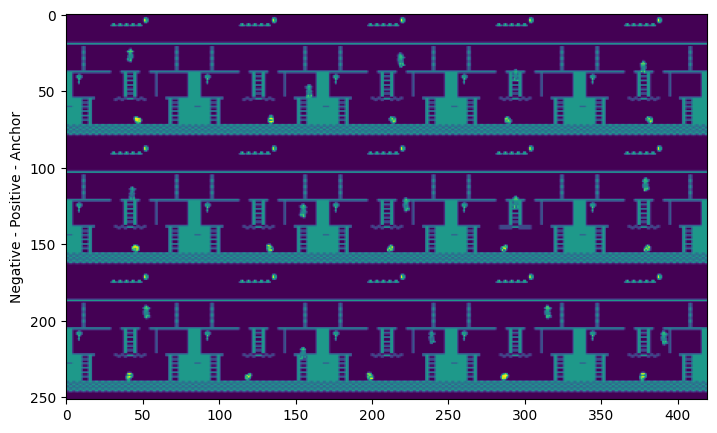

In [297]:
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(np.stack([anchor[:5], positive[:5], negative[:5]]), 'W H h w -> (W h) (H w)'))
plt.ylabel('Negative - Positive - Anchor')

In [298]:
encoder = Encoder((1, 84, 84), 64)

In [333]:

latent_anchor   = encoder(rearrange(anchor,   'bs h w -> bs 1 h w'))
latent_positive = encoder(rearrange(positive, 'bs h w -> bs 1 h w'))
latent_negative = encoder(rearrange(negative, 'bs h w -> bs 1 h w'))

# pos = torch.cosine_similarity(latent_anchor, latent_positive, dim=-1)
# neg = torch.cosine_similarity(latent_anchor, latent_negative, dim=-1)
pos = einsum(latent_anchor, latent_positive, 'bs d, bs d -> bs')
neg = einsum(latent_anchor, latent_negative, 'bs d, bs d -> bs')

loss_pos = (   pos.sigmoid()).log()
loss_neg = (1.-neg.sigmoid()).log()
loss = (loss_pos + loss_neg).mean()
loss.backward()

In [ ]:
def sample_contrastive_batch(obs, p, bs=16):
    t, n, h, w = obs.shape
    i_step, i_env = torch.randint(0, t-1, (bs, )), torch.randint(0, n, (bs, ))
    anchor = obs[i_step, i_env]

    dt_max = t-i_step
    dist = torch.distributions.Geometric(probs=p)
    dt = dist.sample((bs,)).long()+1
    i_step = i_step + (dt % dt_max) # modulo ensures geometric distribution within bounds
    positive = obs[i_step, i_env]

    i_step, i_env = torch.randint(0, t, (bs, )), torch.randint(0, n, (bs, ))
    negative = obs[i_step, i_env]

In [175]:
dist.sample((bs,))

tensor([ 5.,  0.,  1., 24.,  7.,  8., 12., 16.,  0., 13., 41.,  0.,  2.,  4.,
        16.,  5.])

In [171]:
torch.zeros(16, 128)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

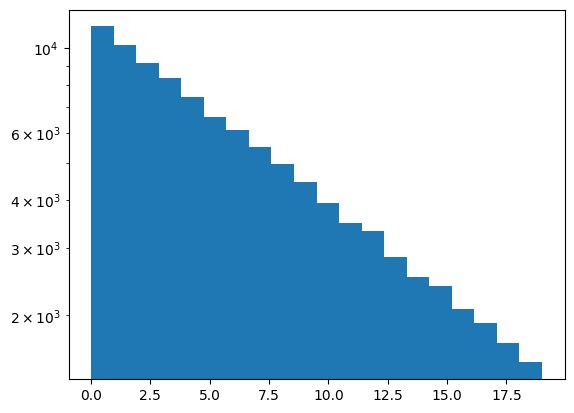

In [186]:
plt.hist(dist.sample((100000,)).numpy()%20, bins=20);
plt.yscale('log')

In [278]:
random.seed(0)
np.random.seed(0)
env = make_env('MontezumaRevenge', n_envs=8, device='mps', seed=0)
obs, info = env.reset()
for _ in tqdm(range(256)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
info['obs'].sum().item()

  0%|          | 0/256 [00:00<?, ?it/s]

6297481

In [996]:
def viz_Cinv(Cinv, xmin=-2, xmax=2, ymin=-2, ymax=2):
    nx, ny = 20, 20
    x = torch.linspace(xmin, xmax, nx)
    y = torch.linspace(ymin, ymax, ny)
    
    x, y = torch.meshgrid(x, y, indexing='ij')
    v = torch.stack([x, y], dim=-1).reshape(nx*ny, 2, 1)
    
    b = v.mT@Cinv@v
    z = b.reshape(nx, ny)
    
    CS = plt.contour(x.numpy(), y.numpy(), z.numpy())
    plt.clabel(CS, inline=True, fontsize=10)
    # plt.grid()
    plt.axhline(); plt.axvline()

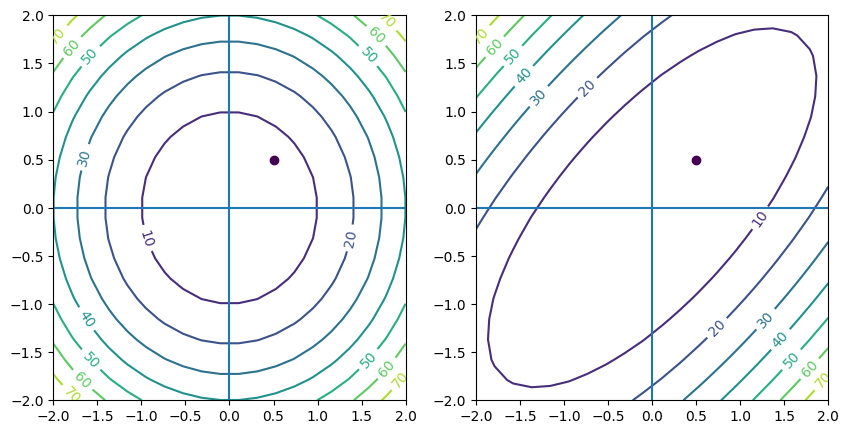

5.0


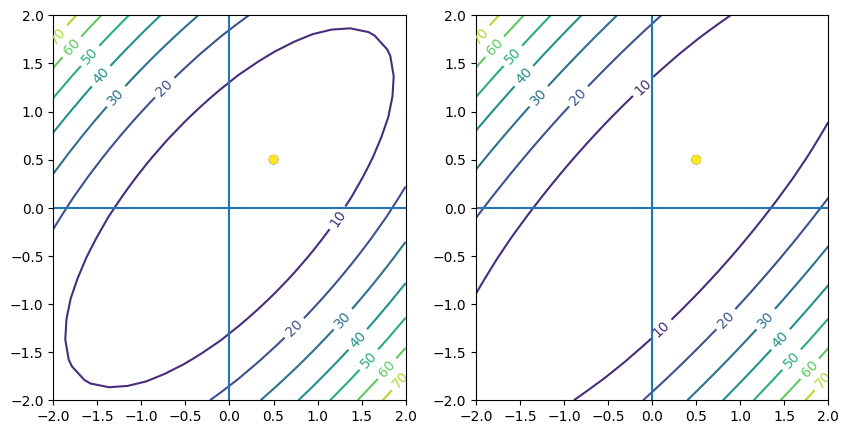

0.8333330154418945


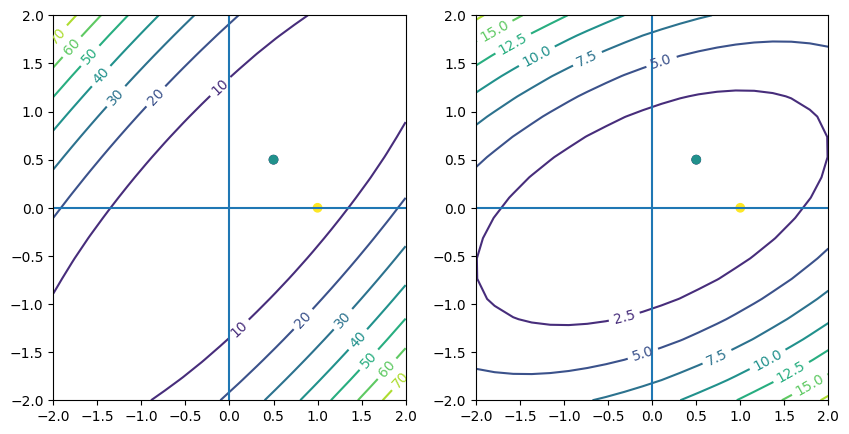

5.454545497894287


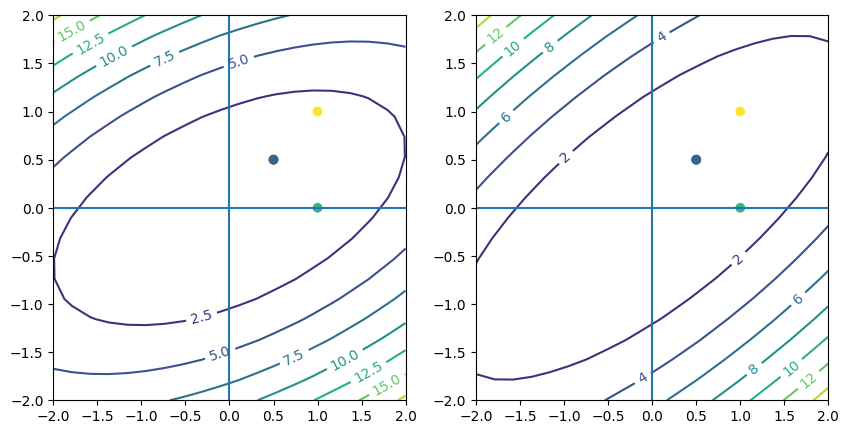

1.690140962600708


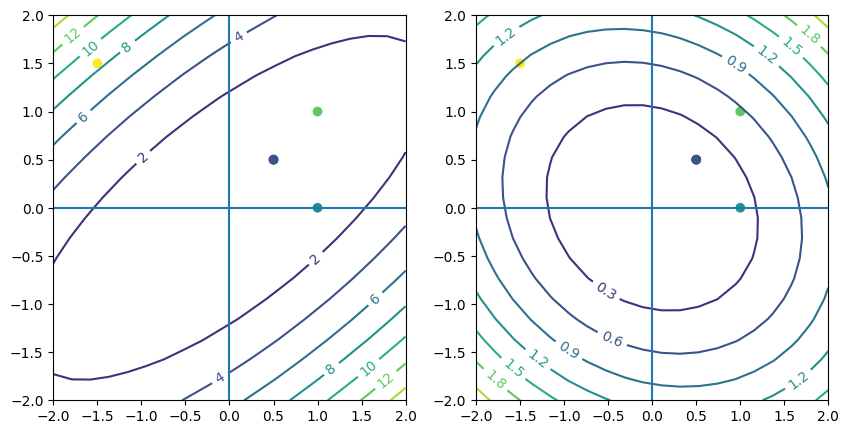

8.481675148010254


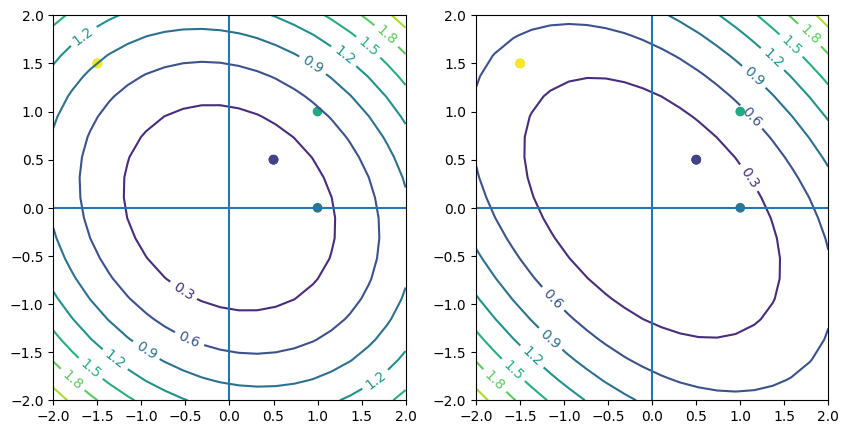

0.8945334553718567


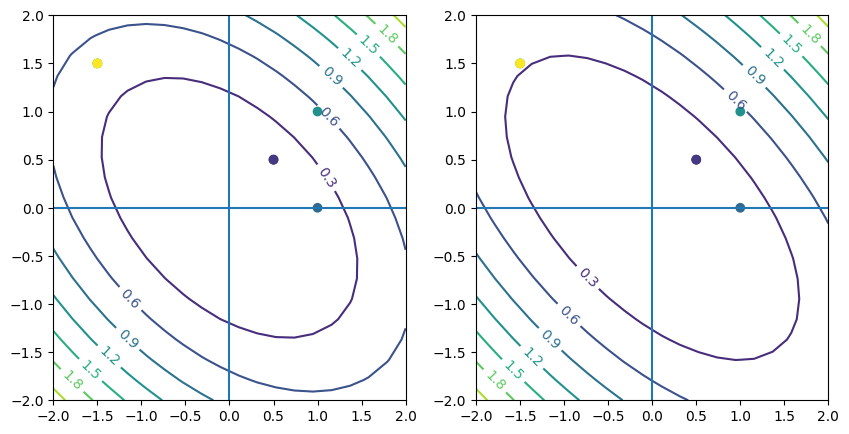

0.4721655249595642


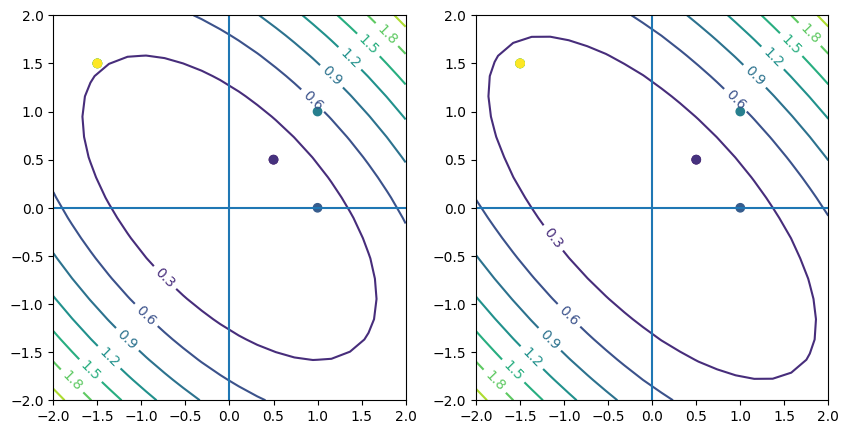

0.3207285404205322


In [997]:
torch.manual_seed(0)
x = torch.randn(10, 2)
x = torch.tensor([
    [0.5, 0.5],
    [0.5, 0.5],
    [1., 0.],
    [1., 1.],
    [-1.5, 1.5],
    [-1.5, 1.5],
    [-1.5, 1.5],
    [-1.5, 1.5],
])
# plt.plot(*x.numpy().T)
# plt.show()

lmbda = 0.1
Cinv = torch.eye(2)/lmbda

for i, v in enumerate(x):
    v = v[:, None]
    b = v.T@Cinv@v
    u = Cinv@v
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(*x[:i+1].numpy().T, c=np.arange(i+1))
    viz_Cinv(Cinv)
    
    Cinv = Cinv - 1/(1+b) * u@u.T
    
    plt.subplot(122)
    viz_Cinv(Cinv)
    plt.scatter(*x[:i+1].numpy().T, c=np.arange(i+1))
    plt.show()
    
    print(b.item())
    

In [433]:
n_steps=300
viz_fast = torch.linspace(0, n_steps, 1000).long().unique()
viz_midd = torch.linspace(0, n_steps, 100).long().unique()
viz_slow = torch.linspace(0, n_steps, 10).long().unique()


In [436]:
set(viz_slow.tolist()) in set(viz_fast.tolist())

False

In [473]:
for n_steps in np.arange(2000, 2100):
    viz_slow = np.clip(n_steps//10, 1, None)
    viz_midd = np.clip(viz_slow//10, 1, None)
    viz_fast = np.clip(viz_midd//10, 1, None)
    print(n_steps, viz_slow, viz_midd, viz_fast)

    a = range(0, n_steps, viz_fast)
    b = range(0, n_steps, viz_midd)
    c = range(0, n_steps, viz_slow)

    assert set(c).issubset(set(b))
    assert set(b).issubset(set(a))
    assert len(a)<=2*1000, len(a)
    assert len(b)<=2*100, len(b)
    assert len(c)<=2*10, len(c)

2000 200 20 2
2001 200 20 2
2002 200 20 2
2003 200 20 2
2004 200 20 2
2005 200 20 2
2006 200 20 2
2007 200 20 2
2008 200 20 2
2009 200 20 2
2010 201 20 2


AssertionError: 

In [488]:
i_step, i_env = torch.arange(128), torch.arange(8)
i_step, i_env = torch.meshgrid(i_step, i_env, indexing='ij')
# i_step, i_env = i_step.flatten(), i_env.flatten()

In [513]:
import sklearn.manifold
X = np.random.randn(100, 64)
y = sklearn.manifold.TSNE().fit_transform(X=X)

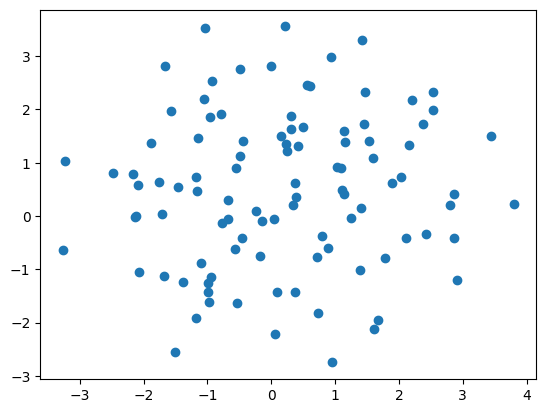

In [514]:
plt.scatter(*y.T)

In [802]:
encoder = Encoder((1, 84, 84), 64).to('mps')
e3b_encode_fn = lambda obs: encoder.encode(obs[:, [-1]])
env = make_env('MontezumaRevenge', n_envs=8, obj='e3b', e3b_encode_fn=e3b_encode_fn, device='mps', seed=0)
obs, info = env.reset()

In [803]:
rews = []
for i in tqdm(range(16)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
    print(info['rew_e3b'].tolist())
    rews.append(info['rew_e3b'].tolist())

  0%|          | 0/16 [00:00<?, ?it/s]

[1.624874472618103, 1.2841408252716064, 1.086050033569336, 0.9800927639007568, 1.5114201307296753, 1.5796754360198975, 1.6853585243225098, 1.4733545780181885]
[1.291414499282837, 0.8833782076835632, 1.0250674486160278, 0.6618218421936035, 1.2418692111968994, 1.2466044425964355, 1.263517141342163, 0.8166036605834961]
[1.022593379020691, 1.231189489364624, 1.4514868259429932, 0.7723671197891235, 0.8864091634750366, 0.9376404881477356, 0.671150803565979, 0.6380727291107178]
[1.101810097694397, 0.9062223434448242, 0.9587159156799316, 1.09522545337677, 0.8672329187393188, 1.0859736204147339, 0.5514737367630005, 0.530238687992096]
[1.0712798833847046, 0.8560227155685425, 0.9534628987312317, 0.9965400695800781, 1.0108325481414795, 1.0618879795074463, 0.6844779849052429, 0.4158579707145691]
[0.8767850995063782, 1.069390058517456, 1.184252142906189, 0.7659475803375244, 0.7883599996566772, 0.8636447191238403, 0.7506515383720398, 0.3730197846889496]
[0.9607881903648376, 0.8631395101547241, 0.8449

In [804]:
rews = np.array(rews)

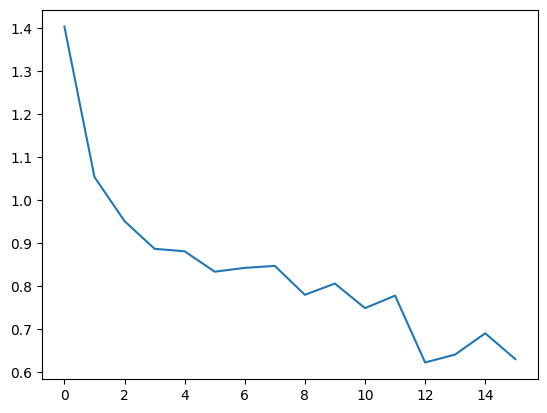

In [805]:
plt.plot(rews.mean(axis=-1))

In [808]:

env.key2past_rets.keys()

dict_keys(['ret_ext', 'ret_alive', 'ret_e3b'])

In [762]:
env.key2running_ret

{'ret_ext': tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='mps:0'),
 'ret_alive': tensor([2., 2., 2., 2., 2., 2., 2., 2.], device='mps:0'),
 'ret_e3b': tensor([2.2835, 1.8240, 1.7336, 1.4986, 2.1127, 2.2432, 2.0954, 1.9460],
        device='mps:0')}

In [792]:
encoder = Encoder((1, 84, 84), 5).to('cpu')
e3b_encode_fn = lambda obs: encoder.encode(obs[:, [-1]])
env = make_env('MontezumaRevenge', n_envs=8, obj='ext', e3b_encode_fn=e3b_encode_fn, device='cpu', seed=0)
obs, info = env.reset()

In [793]:
latent = encoder.encode(info['obs'][:, [-1]]).cpu()

In [794]:
Cinv = torch.zeros(8, 5, 5)
Cinv[:] = torch.eye(5)/0.1
# latent = torch.randn(8, 64)
# latent = latent/latent.norm(dim=-1, keepdim=True)
v = latent[..., :, None]  # b, d, 1
print(f'{v.sum().item()=}')
u = Cinv @ v  # b, d, 1
print(f'{u.sum().item()=}')
b = v.mT @ u  # b, 1, 1
print(f'{b.sum().item()=}')
print(torch.linalg.eig(Cinv.cpu()).eigenvalues.real.min(dim=-1).values.tolist())
print(f'{Cinv.sum().item()=}')
Cinv = Cinv - u @ u.mT / (1.0 + b)  # b, d, d
print(f'{Cinv.sum().item()=}')
print(torch.linalg.eig(Cinv.cpu()).eigenvalues.real.min(dim=-1).values.tolist())

v.sum().item()=-3.4350593090057373
u.sum().item()=-34.35059356689453
b.sum().item()=80.0
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Cinv.sum().item()=400.0
Cinv.sum().item()=386.30426025390625
[0.9090917110443115, 0.909091591835022, 0.9090905785560608, 0.9090909957885742, 0.909091591835022, 0.909091591835022, 0.9090917110443115, 0.9090916514396667]


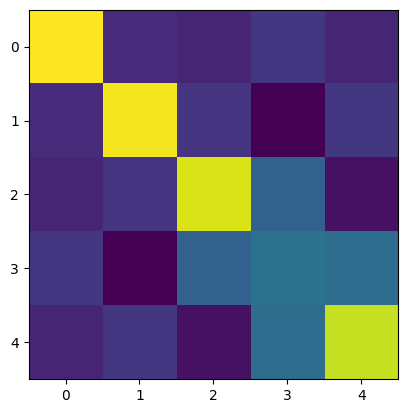

In [795]:
plt.imshow(Cinv[0].detach().cpu().numpy())

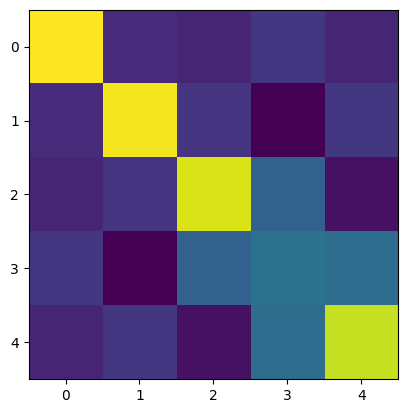

In [796]:
plt.imshow(env.Cinv[0].detach().cpu().numpy())

In [797]:
assert torch.allclose(env.u, u)
assert torch.allclose(env.v, v)
assert torch.allclose(env.b, b)

In [811]:
torch.distributions.Geometric(probs=torch.tensor(.5, device='mps')).sample()

tensor(1., device='mps:0')

In [876]:
for n_steps in tqdm(range(1, 10000)):
    viz_fast = set(np.linspace(0, n_steps-1, 1000).astype(int))
    assert len(viz_fast) == min(n_steps, 1000), n_steps

  0%|          | 0/9999 [00:00<?, ?it/s]

In [884]:
n_steps = 15
viz_slow = set(np.linspace(0, n_steps-1,   10).astype(int))
viz_midd = set(np.linspace(0, n_steps-1,  100).astype(int)).union(viz_slow)
viz_fast = set(np.linspace(0, n_steps-1, 1000).astype(int)).union(viz_midd)

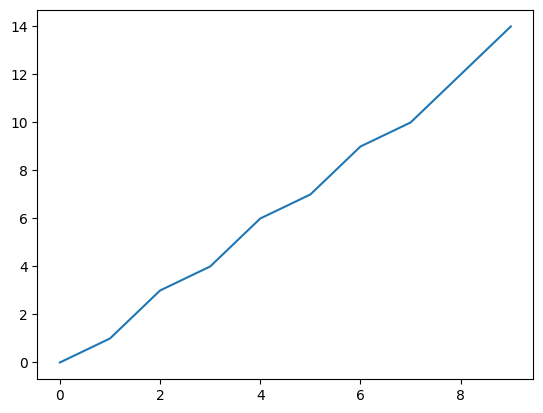

In [885]:
# plt.plot(sorted(list(viz_fast)))
# plt.plot(sorted(list(viz_midd)))
plt.plot(sorted(list(viz_slow)))

In [1017]:
q = torch.randn(8, 16, 128).to('mps')
k = torch.randn(8, 16, 128).to('mps')
v = torch.randn(8, 16, 128).to('mps')

In [1018]:
%%timeit
a = nn.functional.scaled_dot_product_attention(q, k, v)

238 µs ± 2.98 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1019]:
%%timeit
b = ((q @ k.mT)/np.sqrt(q.shape[-1])).softmax(dim=-1)@v

158 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [1054]:
mha = nn.MultiheadAttention(128, 4, bias=True)

In [1056]:
print([p.shape for p in mha.parameters()])
print(sum(p.numel() for p in mha.parameters()))

[torch.Size([384, 128]), torch.Size([384]), torch.Size([128, 128]), torch.Size([128])]
66048


In [1061]:
list(mha.modules())

[MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
 ),
 NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)]

In [1064]:
dir(mha)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_qkv_same_embed_dim',
 '_register_

In [1119]:
net = nn.LayerNorm(128)
nn.init.constant_(net.weight, 2.)
net.bias = None
# nn.init.constant_(net.bias, 1.);


In [1120]:
a = torch.randn(16, 128)
a = (a-a.mean(dim=-1, keepdim=True))/a.var(dim=-1, keepdim=True, correction=0).sqrt()

In [1122]:
b = net(a)
c = a*2

torch.allclose(b, c, atol=1e-4)

True

In [1123]:
mha

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
)

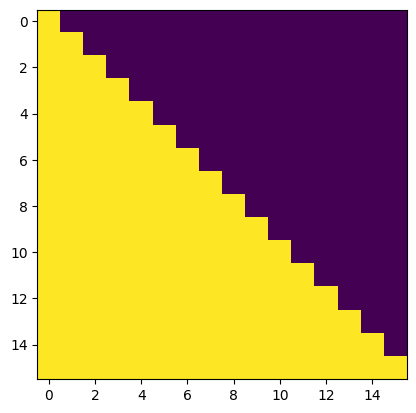

In [1126]:
plt.imshow(torch.ones(16, 16).tril().numpy())

In [1129]:
nn.Linear(128, 100).weight.shape

torch.Size([100, 128])

In [1130]:
nn.Embedding(100, 128).weight.shape

torch.Size([100, 128])

In [1198]:
batch_size = 1
n_embd = 2
# timesteps = torch.ones(batch_size, 1, 1).long()
timesteps = torch.arange(6)[None, :, None]

token_embeddings = torch.randn(batch_size, 15, n_embd)

pos_emb = nn.Parameter(torch.zeros(1, 15 + 1, n_embd))
global_pos_emb = nn.Parameter(torch.zeros(1, 5+1, n_embd))

pos_emb.data[0, :, 0] = torch.arange(16)
global_pos_emb.data[0, :, 1] = torch.arange(6)


all_global_pos_emb = torch.repeat_interleave(global_pos_emb, batch_size, dim=0) # batch_size, traj_length, n_embd
position_embeddings = torch.gather(all_global_pos_emb, 1, torch.repeat_interleave(timesteps, n_embd, dim=-1)) + pos_emb[:, :token_embeddings.shape[1], :]


position_embeddings

tensor([[[0., 0.],
         [0., 1.],
         [0., 2.],
         [0., 3.],
         [0., 4.],
         [0., 5.]]], grad_fn=<GatherBackward0>)

In [1195]:
timesteps = torch.arange(6)[None, :, None]
# timesteps = torch.ones(batch_size, 1, 1).long()
# timesteps = 
timesteps.shape

torch.Size([1, 6, 1])

In [1196]:
all_global_pos_emb.shape

torch.Size([1, 6, 2])

In [1197]:
torch.gather(all_global_pos_emb, 1, torch.repeat_interleave(timesteps, n_embd, dim=-1))

tensor([[[0., 0.],
         [0., 1.],
         [0., 2.],
         [0., 3.],
         [0., 4.],
         [0., 5.]]], grad_fn=<GatherBackward0>)

In [1162]:
position_embeddings

tensor([[[ 0.,  1.],
         [ 1.,  1.],
         [ 2.,  1.],
         [ 3.,  1.],
         [ 4.,  1.],
         [ 5.,  1.],
         [ 6.,  1.],
         [ 7.,  1.],
         [ 8.,  1.],
         [ 9.,  1.],
         [10.,  1.],
         [11.,  1.],
         [12.,  1.],
         [13.,  1.],
         [14.,  1.]]], grad_fn=<AddBackward0>)

In [1167]:
timesteps, timesteps.shape

(tensor([[[0],
          [1],
          [2],
          [3],
          [4]]]),
 torch.Size([1, 5, 1]))

In [1216]:
a = torch.randn(1, 10, 128)
b = torch.randn(1, 10, 128)
c = torch.randn(1, 10, 128)

In [1220]:
x = torch.randn(1, 30, 128)
x[:, 0::3, :] = a
x[:, 1::3, :] = b
x[:, 2::3, :] = c

In [1221]:
y = torch.stack([a,b,c], dim=2).reshape(1, 30, 128)

In [1222]:
torch.allclose(x, y)

True

In [1223]:
torch.stack([a,b,c], dim=2).shape

torch.Size([1, 10, 3, 128])

In [1344]:
done = torch.rand(size=(2, 30,))<0.1

In [1345]:
done[:, 0] = True

In [1346]:
print(done.shape)
done

torch.Size([2, 30])


tensor([[ True, False, False, False, False, False,  True,  True, False, False,
         False, False, False, False, False, False, False,  True, False,  True,
         False,  True, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False,  True, False, False,
         False,  True, False, False, False, False, False, False,  True, False,
         False, False, False, False, False,  True, False, False, False, False]])

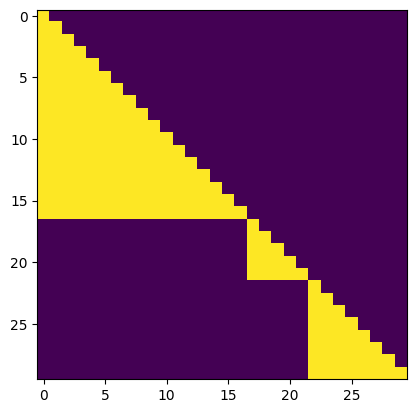

In [1280]:
# mask = torch.ones(30, 30, dtype=torch.bool).tril()
mask = torch.zeros(30, 30, dtype=torch.bool)
for i, di in enumerate(done.tolist()):
    idx = 0
    for j in range(i, 0, -1):
        if done[j].item():
            idx = j
            break
    mask[i, idx:i+1] = True
plt.imshow(mask.numpy())

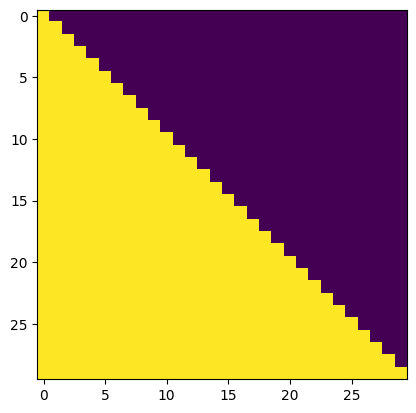

In [1301]:
mask = torch.ones(30, 30, dtype=torch.bool).tril()
plt.imshow(mask.numpy())

In [1303]:
torch.where(done)

(tensor([ 0, 17, 22]),)

In [1304]:
torch.where(torch.stack([done, done, done]))

(tensor([0, 0, 0, 1, 1, 1, 2, 2, 2]),
 tensor([ 0, 17, 22,  0, 17, 22,  0, 17, 22]))

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 17,
        17, 17, 17, 17, 22, 22, 22, 22, 22, 22, 22, 22])


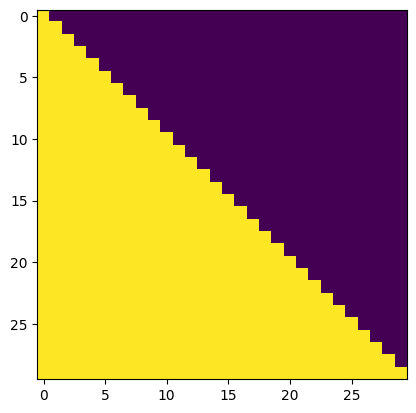

In [1308]:
mask = torch.ones(30, 30, dtype=torch.bool).tril()
a = done.cummax(dim=-1).indices

print(a)
# mask[:, a: torch.arange(3)]
plt.imshow(mask.numpy())

In [1358]:
done = torch.zeros(30, 2, dtype=bool)
done[::6, :] = True

In [1366]:
done = torch.rand(size=(30, 2))<0.1

torch.Size([2, 30, 30])

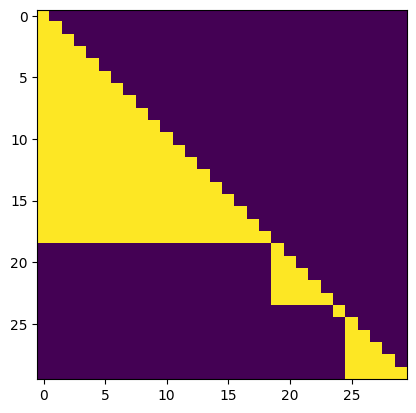

In [1380]:
def create_mask(done, toks=1):
    t, b = done.shape
    mask = torch.ones(b, t*toks, t*toks, dtype=torch.bool, device=done.device).tril()
    for i in range(t):
        # when done=True, me+future (i:) CANNOT attend to past (:i)
        mask[done[i], i*toks:, :i*toks] = False
    return mask

mask = create_mask(done)

plt.imshow(mask[0].numpy())
mask.shape

In [1384]:
agent = Agent((1, 84, 84), 15)

'../data/egb-atari-1/Breakout_ext_0'

In [1401]:
os.makedirs('../data/egb-atari-1/Breakout/agent.pt', exist_ok=True)
torch.save(agent.state_dict(), '../data/egb-atari-1/Breakout/agent.pt')

RuntimeError: File ../data/egb-atari-1/Breakout/agent.pt cannot be opened.

In [1399]:
torch.save(agent.state_dict(), '../data/egb-atari-1/breakout_ext_0/agent.pt')

RuntimeError: Parent directory ../data/egb-atari-1/Breakout_ext_0 does not exist.

In [ ]:
torch.save(agent.state_dict(), '../data/egb-atari-1/Breakout_ext_0/agent.pt')

In [1419]:
env = make_env('BeamRider')
env.reset()
for i in tqdm(range(1000)):
    obs, rew, term, trunc, info = env.step(env.action_space.sample())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
obs = torch.randn(128, 8, 100)
obs.shape

torch.Size([128, 8, 100])

In [7]:
i_step = torch.randint(0, 128-5, (16,), device='cpu')
i_env = torch.randint(0, 8, (16,), device='cpu')


torch.Size([128, 8, 100])

In [20]:
def select1():
    trajs = []
    for i, j in zip(i_step.tolist(), i_env.tolist()):
        trajs.append(obs[i: i+5, j])
    return torch.stack(trajs)

def select2():
    return torch.stack([obs[i:i+5, j] for i, j in zip(i_step.tolist(), i_env.tolist())])

In [23]:
select2().shape

torch.Size([16, 5, 100])

In [30]:
dist = torch.distributions.Categorical(logits=torch.randn(32, 32, 15))

In [32]:
dist.entropy().shape

torch.Size([32, 32])

In [33]:
env = make_env()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [41]:
obs, info = env.reset()
for i in range(3):
    pobs = info['obs']
    obs, rew, term, trunc, info = env.step(env.action_space.sample())
    nobs = info['obs']

In [47]:
print(pobs.shape, nobs.shape)
print(torch.allclose(pobs, nobs))
print(torch.allclose(pobs[:, 1:], nobs[:, :3]))

torch.Size([8, 4, 84, 84]) torch.Size([8, 4, 84, 84])
False
True
